**Project 1 Phase 2**<br>
<br>
<table style="width:100%">
  <tr>
    <th style = "text-align: left">#</th>
    <th style = "text-align: left">Name</th>
    <th style = "text-align: left">Lastname</th>
    <th style = "text-align: left">Matr Number</th>
  </tr>
  <tr>
    <td style = "text-align: left">1</td>
    <td style = "text-align: left">Christian</td>
    <td style = "text-align: left">Peinthor</td>
    <td style = "text-align: left">11815592</td>
  </tr>
  <tr>
    <td style = "text-align: left">2</td>
    <td style = "text-align: left">Michael</td>
    <td style = "text-align: left">Weikl</td>
    <td style = "text-align: left">1154652</td>
  </tr>
  <tr>
    <td style = "text-align: left">2</td>
    <td style = "text-align: left">Uros</td>
    <td style = "text-align: left">Zivanovic</td>
    <td style = "text-align: left">12032271</td>
  </tr>
  
</table>
<br>

# Table of contents
* [Problemdefinition](#Problemdefinition)
* [Basic functions](#Basic-functions)
    * [Stopping Criterion](#Stopping-Criterion)
    * [Backtracking](#Backtracking)
    * [Wolfe Condition](#Wolfe-Condition)
    * [Derivation (Taylor-Theorem)](Derivation-(Taylor-Theorem))
* [Implementation of the algorithms](#Implementation-of-the-algorithms)
    * [Steepest descent](#Steepest-descent)
    * [Newthon method](#Newthon-method)
    * [Fetcher Reeves](#Fetcher-Reeves)
    * [SR1](#SR1)
* [Executions](#Executions)


In [1]:
import numpy as np
import scipy 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from numpy.linalg import *

# Problem Definitions

Basic Problem class to set up problems for the algorithms to be solved.

In [2]:
class Problem():
    def f(self, x):
        raise NotImplementedError("f() is not implemented for this Problem")
    
    def grad_f(self, x):
        raise NotImplementedError("grad_f() is not implemented for this Problem")
            
    def hessian(self, x):
        raise NotImplementedError("hessian() is not implemented for this Problem")      
        

## Polynomials

In [3]:
 class PolynomialProblem(Problem):
        @property
        def actual_minima(self):
            raise NotImplementedError("actual_minima() is not implemented for this Problem")      


############################################################
#                Polynomial definitions
############################################################
class Himmelblau(PolynomialProblem):
    def f(self, x):
        return (x[0] ** 2 + x[1] - 11) ** 2 + (x[0] + x[1] ** 2 - 7) ** 2
    
    def grad_f(self, x):
        return np.array([4*x[0]*(x[0]**2 + x[1] - 11)+2*(x[0] + x[1]**2 - 7),
                         4*x[1]*(x[1]**2 + x[0] - 7)+2*(x[1] + x[0]**2 - 11)])
    
    def hessian(self, x):
        return np.array([[12*x[0]**2 + 4*x[1] - 42, 
                          4*(x[1] + x[0])],
                         [4*(x[1] + x[0]),
                          12*x[1]**2 + 4*x[0] - 26]])
    
    @property
    def actual_minima(self):
        return np.array([[3,2], 
                         [-2.805118, 3.131312], 
                         [-3.779310, -3.283186], 
                         [3.584428, -1.848126]])

    
class Polynomial1(PolynomialProblem):
    def f(self, x):
        return ((x - 7)**2 * (x - 3)**2) / 4
    
    def grad_f(self, x):
        return (x - 7) * (x - 5) * (x - 3)
    
    def hessian(self, x):
        return 3 * x**2 - 30 * x + 71
    
    @property
    def actual_minima(self):
        return np.array([[3],[5],[7]])

    
class Rosenbrock(PolynomialProblem):
    def f(self, x):
        return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

    def grad_f(self, x):
        return np.array([-400*x[0]*(x[1] - x[0]**2) - 2*(1 - x[0]),
                         200*(x[1] - x[0]**2)])

    def hessian(self, x):
        return np.array([[-400*(x[1] - 3*x[0]**2) + 2, 
                          -400*x[0]],
                         [-400*x[0], 
                          200]])
    
    @property
    def actual_minima(self):
        return np.array([1,1])


#this is the function below rosenbrock defined in the project description
class Function2(PolynomialProblem):
    def f(self, x):
        return 150*(x[0] * x[1])**2 + (0.5 * x[0] + 2 * x[1] - 2)**2
    
    def grad_f(self, x):
        return np.array([x[0] * (300 * x[1]**2 + 0.5) + 2 * x[1] - 2, 300*x[0]**2 * x[1] + 2 * x[0] + 8 * x[1] - 8])

    def hessian(self, x):
        return np.array([[300 * x[1]**2 + 0.5, 600 * x[0]*x[1] + 2],[600 * x[0]*x[1] + 2, 300 * x[0]**2 + 8]])

    #self calculated minima
    @property
    def actual_minima(self):
        return np.array([[0,1],[4,0]])

## Squared Error

In [4]:
# Helper functions for squared error problems
def normal_distributed_data_points(target_function, q: float, num_points: int):
    # bring normal distributed value from range [0, 1] to  [-q, q]
    return distributed_data_points(target_function=target_function, q=q, num_points=num_points,
                                   distribution=lambda r: (np.random.normal(0, scale=2 * r) - r))


def uniform_distributed_data_points(target_function, q: float, num_points: int):
    return distributed_data_points(target_function=target_function, q=q, num_points=num_points,
                                   distribution=lambda r: np.random.uniform(low=-r, high=r))


def distributed_data_points(target_function, q: float, num_points: int, distribution):
    result_list = []

    for _ in range(num_points):
        val = distribution(abs(q))
        result_list.append((val, target_function(val)))

    return result_list

In [5]:
class SquaredErrorProblem(Problem):
    def __init__(self, target_function,
                 q: int = 2, num_points: int = 100, degree: int = 5,
                 random_seed: int = 1154652, distribution='uniform'):
        if distribution == 'uniform':
            self.data = uniform_distributed_data_points(target_function=target_function, q=q, num_points=num_points)
        elif distribution == 'normal':
            self.data = normal_distributed_data_points(target_function=target_function, q=q, num_points=num_points)
        else:
            raise NotImplementedError(
                f"Functionality not implemented for ditribution type '{distribution}'. Use 'uniform' or 'normal'.")

        self.coefficients = []
        for j in range(num_points):
            a_j = self.data[j][0]
            c_j = np.reshape([a_j ** i for i in range(degree + 1)], (degree + 1, 1))
            self.coefficients.append(c_j)

        self.target_function = target_function

    def __residual(self, x, j):
        a_j = self.data[j][0]
        b_j = self.data[j][1]
        c_j = self.coefficients[j]

        return c_j.T @ x - b_j

    def f(self, x):
        return 1 / 2 * np.sum([self.__residual(x, j) ** 2 for j in range(len(self.data))])

    def grad_f(self, x):
        return np.sum([self.__residual(x, j) * self.coefficients[j] for j in range(len(self.data))], axis=0)

    def hessian(self, x):
        return np.sum([self.coefficients[j] @ self.coefficients[j].T for j in range(len(self.data))], axis=0)


############################################################
#              Squared Error Problem Definition
############################################################

class SinusSQEP(SquaredErrorProblem):
    def __init__(self, q: int = 2, num_points: int = 100, degree: int = 5,
                 random_seed: int = 1154652, distribution='uniform'):
        super().__init__(lambda x: np.sin(x), q, num_points, degree, random_seed, distribution)


class CosinusSQEP(SquaredErrorProblem):
    def __init__(self, q: int = 2, num_points: int = 100, degree: int = 5,
                 random_seed: int = 1154652, distribution='uniform'):
        super().__init__(lambda x: np.cos(x), q, num_points, degree, random_seed, distribution)


class SinusMinusCosinusSQEP(SquaredErrorProblem):
    def __init__(self, q: int = 2, num_points: int = 100, degree: int = 5,
                 random_seed: int = 1154652, distribution='uniform'):
        super().__init__(lambda x: np.sin(x) - np.cos(x), q, num_points, degree, random_seed, distribution)


class CubePlusSquareSQEP(SquaredErrorProblem):
    def __init__(self, q: int = 2, num_points: int = 100, degree: int = 5,
                 random_seed: int = 1154652, distribution='uniform'):
        super().__init__(lambda x: x ** 3 + x ** 2, q, num_points, degree, random_seed, distribution)


class SinusPlusCosinusSQEP(SquaredErrorProblem):
    def __init__(self, q: int = 2, num_points: int = 100, degree: int = 5,
                 random_seed: int = 1154652, distribution='uniform'):
        super().__init__(lambda x: 3 * np.sin(x) + np.cos(x), q, num_points, degree, random_seed, distribution)

# Basic functions

## Stopping Criterion

This implements a stopping criterion for when the gradient of f at xk is small relative to the gradient of f at x0
Also a maxmimum number of iterations is implemented.

In [6]:
def stop_crit(grad_f, xk, x0, current_iteration, tol: float = 1e-8, max_iter: int = 1000):
    if current_iteration > max_iter:
        return True
    elif norm(grad_f(xk)) <= tol * norm(grad_f(x0)):
        return True
    return False

## Backtracking

Backtracking linesearch to find suitable step length as described in the book. steepest_descent() implements the line search steepest descent method.

In [7]:
def backtracking_alpha(f, grad_f, xk, pk, alpha0=1, rho=0.95, c=1e-4):
    alpha = alpha0
    f_xk = f(xk)
    grad_f_xk = grad_f(xk)

    while f(xk + alpha * pk) > (f_xk + c * alpha * grad_f_xk.T @ pk):
        alpha *= rho

    return alpha

## Wolfe Condition

alpha_wolfe() returns a step length satisfiying the weak wolfe conditions using a bisection approach as described in https://sites.math.washington.edu/~burke/crs/408/notes/nlp/line.pdf. newton_method() implements the line search Newton method solving the equation H @ pk = -grad instead of computing the inverse of H.

In [8]:
def alpha_wolfe(f, grad_f, xk, pk, c1=1e-4, c2=0.9):
    alpha = 0
    beta = np.Inf
    t = 1

    while True:
        if f(xk + t * pk) > (f(xk) + c1 * t * (pk.T @ grad_f(xk))):
            beta = t
            t = 0.5 * (alpha + beta)
        elif (-pk.T @ grad_f(xk + t * pk)) > (-c2 * pk.T @ grad_f(xk)):
            alpha = t
            t = (2 * alpha if beta == np.Inf else 0.5 * (alpha + beta))
        else:
            return t

## Derivation (Taylor Theorem)

This implements the forward difference approach from the book for gradient and hessian calculation without explicit function knowledge.

In [9]:
def e_i(size, index):
    arr = np.zeros(size)
    arr[index] = 1.0
    return arr


# these return the function that computes the gradient, which can then in turn be called to compute the gradient
def approx_grad(f, e=1.1e-8):
    def grad_f(x):
        if x.size == 1:
            return (f(x + e) - f(x)) / e
        return np.array([(f(x + e * e_i(x.size, i)) - f(x)) / e for i in range(x.size)])

    return grad_f


def approx_hessian(f, e=1.1e-8):
    def hessian_f(x):
        if x.size == 1:
            return (f(x + 2 * e) - 2 * f(x + e) + f(x)) / e ** 2
        return np.array([[(f(x + e * e_i(x.size, i) + e * e_i(x.size, j)) - f(
            x + e * e_i(x.size, i)) - f(x + e * e_i(x.size, j)) + f(
            x)) / e ** 2 for j in range(x.size)] for i in range(x.size)])

    return hessian_f

# Implementation of the algorithms

## Steepest descent

In [10]:
def steepest_descent(x0, f, grad_f=None, initial_alpha: float = 1e-3, tolerance: float = 1e-8):
    if grad_f == None:
        grad_f = approx_grad(f)

    i = 1
    xk = x0
    search_alpha, alpha, pk = None, None, None

    while not stop_crit(grad_f, xk, x0, i, tol=tolerance):

        if search_alpha is None:
            search_alpha = initial_alpha
            pk = -grad_f(xk)
        else:
            new_pk = -grad_f(xk)
            search_alpha = alpha * (-pk.T @ pk) / (-new_pk.T @ new_pk)
            pk = new_pk

        alpha = backtracking_alpha(f, grad_f, xk, pk)
        xk = xk + alpha * pk

        i += 1

    return xk, i

## Newton method

In [11]:
def newton_method(x0, f, grad_f=None, hessian_f=None, tolerance=1e-8):
    if grad_f == None:
        grad_f = approx_grad(f)
        hessian_f = approx_hessian(f)
    i = 1
    x = x0

    while not stop_crit(grad_f, x, x0, i, tol=tolerance):
        pk = np.array([- (1 / hessian_f(x)) @ grad_f(x)]) if x.size == 1 else solve(hessian_f(x), -grad_f(x))
        x = x + alpha_wolfe(f, grad_f, x, pk) * pk
        i += 1

    #print(f"\n Search terminated after iteration {i} with result: {x}")
    return x, i

## Fetcher Reeves

Implementation of the Fletcher Reeves nonlinear conjugate gradient method.

In [12]:
def FR(x0, f, grad_f=None):

    conv_tol = 1e-8
    if grad_f == None:
        grad_f = approx_grad(f)
    i = 0
    xk = x0
    pk = -grad_f(xk)

    while not stop_crit(grad_f, xk, x0, i, tol=conv_tol):

        xk1 = xk + backtracking_alpha(f, grad_f, xk, pk) * pk
        beta = (grad_f(xk1) @ grad_f(xk1)) / (grad_f(xk) @ grad_f(xk))
        pk = -grad_f(xk1) + beta * pk
        xk = xk1
        i += 1
 
    #print(f"\n Search terminated after iteration {i} with result: {xk}")
    return xk

## BFGS

In [13]:

def approx_hessian_bfgs(f_grad, B_k, x_1, x):
    """
    Approximate Hessian based on first derivitive.
    :param f_grad: first derivitive of f
    :param B_k: current hessian
    :param x_1: x_{k+1}
    :param x: x_{k}
    :return: approximated hessian
    """

    s_k = x_1 - x
    y_k = f_grad(x_1) - f_grad(x)

    return B_k - (B_k * s_k * np.transpose(s_k) * B_k) / \
           (np.transpose(s_k) * B_k * s_k) + \
           (y_k * np.transpose(y_k)) / (np.transpose(y_k) * s_k)


def BFGS(x0, f):
    tolerance = 1e-8
    H = np.eye(x0.shape[0])
    x = x0

    f_grad = approx_grad(f)

    for _ in range(1000):

        f_x = f_grad(x)

        if np.all(np.abs(H)) < tolerance:
            return x

        x_old = x
        x = x - f_x / H
        H = approx_hessian_bfgs(f_x, H, f_grad(x), x_old)

    return x

## Fletcher Reeves

SR1() implements the line search quasi newton method utilizing SR1 updating for inverse Hessian approximation and a method for stabilizing that resets H as a multiple of I inspired by the method deployed in https://www.sciencedirect.com/science/article/pii/S0898122111004202?via%3Dihub.

In [14]:
def SR1(x0 : np.array, f, grad_f, r=1e-8):

    conv_tol = 1e-8
    i = 0
    H = np.identity(x0.size)
    x = x0

    while not stop_crit(grad_f, x, x0, i, tol=conv_tol):
  
        pk = - H @ grad_f(x)
        x_1 = x + alpha_wolfe(f, grad_f, x, pk) * pk
        sk = x_1 - x
        yk = grad_f(x_1) - grad_f(x)
        rhok = 1 / (yk.T @ sk)
    
        if ((sk @ yk - yk @ H @ yk) < 0) or (abs(yk @ (sk - H @ yk)) < r * np.linalg.norm(yk) * np.linalg.norm(sk - H @ yk)) or (
            norm(H, np.inf) > 1e10):
            mu = (sk @ sk) / (yk @ sk) - ((sk @ sk)**2 / (yk @ sk)**2 - (sk @ sk) / (yk @ yk))**0.5
            H_1 = mu * np.identity(x0.size)
            H = H_1
        else:
            H_1 = H + np.outer((sk - H @ yk), (sk - H @ yk)) / ((sk - H @ yk) @ yk)
            H = H_1
        
        x = x_1
        i += 1

    #print(f"\n Search terminated after iteration {i} with result: {x}")
    return x

# Executions

In [15]:
# Define list with all possible algorithms for the tests
algorithms = {'Steepest descent': steepest_descent,
              'Newthon method': newton_method,
              'Fetcher Reeves': FR,
              'SR1': SR1,
              'BFGS': BFGS}

## Polynomial Problems

In [16]:
polynomial_problems = {Himmelblau(): [0,0], 
                       Polynomial1(): [1]   }

for prob, start_value in polynomial_problems.items():
    
    print("**********************************************")
    print(f"Problem {type(prob).__name__}:")
    print("**********************************************")
    for algorithm_name, algorithm in algorithms.items():
        try:
            print("------------------------------------------------")
            print(f"\tAlgorithm '{algorithm_name}':")
            print("------------------------------------------------")
            parameters = {'x0': np.array(start_value),
                          'f': prob.f,
                          'grad_f': prob.grad_f,
                          'hessian_f': prob.hessian}

            # clean up parameters for generic method call
            possible_parameters = algorithm.__code__.co_varnames
            for p in list(parameters):
                if p not in possible_parameters:
                    parameters.pop(p)

            x, iterations = algorithm(**parameters)

            print(f"Search terminated after iteration {iterations} with result: {x}")
            print(f"Last gradient norm: {norm(prob.grad_f(x))}")
            print("Difference to real solutions:")
            for am in prob.actual_minima:
                print(f"\tDifference to point '{am}' is {norm(x - am)}")
        
        except Exception:
            print(f"Algorithm '{algorithm_name}' failed to find a solution")

        


# prob = Problem()
# prob.poly_1()
# print(f"\nProblem poly_1: \n")
# print("\nAlgorithm output exact gradient: ")
# x_ = steepest_descent(np.array([1]), prob.f, prob.grad_f)
# print(f"\nactual minima: {prob.min_x}")
# print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
# print(f"\nDifference to real solution: {norm(x_ - prob.min_x[2])}")
# print("\nAlgorithm output approximated gradient: ")
# x_ = steepest_descent(np.array([1]), prob.f)
# print(f"\nactual minima: {prob.min_x}")
# grad = approx_grad(prob.f)
# print(f"\nLast gradient norm: {norm(grad(x_))}")
# print(f"\nDifference to real solution: {norm(x_ - prob.min_x[2])}")

**********************************************
Problem Himmelblau:
**********************************************
------------------------------------------------
	Algorithm 'Steepest descent':
------------------------------------------------
Search terminated after iteration 1001 with result: [-3.77938833 -3.28313757]
Last gradient norm: 0.012291634078248615
Difference to real solutions:
	Difference to point '[3. 2.]' is 8.594861759349271
	Difference to point '[-2.805118  3.131312]' is 6.4880171015771
	Difference to point '[-3.77931  -3.283186]' is 9.209415959377343e-05
	Difference to point '[ 3.584428 -1.848126]' is 7.502336244619459
------------------------------------------------
	Algorithm 'Newthon method':
------------------------------------------------
Search terminated after iteration 1001 with result: [-3.49888468e-16 -8.88178420e-16]
Last gradient norm: 26.076809620810565
Difference to real solutions:
	Difference to point '[3. 2.]' is 3.6055512754639905
	Difference to point 

## Squared Error Problem

**********************************************
Problem SinusSQEP:
**********************************************
------------------------------------------------
	Algorithm 'Steepest descent':
------------------------------------------------
Search terminated after iteration 1001 with result: [[-0.00152856]
 [ 0.81234808]
 [ 0.01702479]
 [ 0.03512928]
 [-0.00662312]
 [-0.03741755]]
Last gradient norm: 5.541382771875275


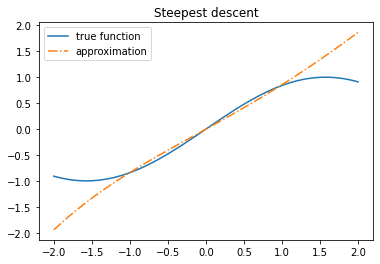

------------------------------------------------
	Algorithm 'Newthon method':
------------------------------------------------
Search terminated after iteration 2 with result: [[ 5.05096262e-05]
 [ 9.99149991e-01]
 [-9.65727120e-05]
 [-1.64589694e-01]
 [ 3.01540878e-05]
 [ 7.14423682e-03]]
Last gradient norm: 1.427703478112118e-13


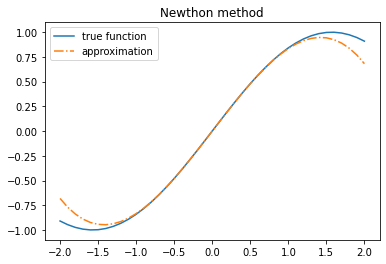

------------------------------------------------
	Algorithm 'Fetcher Reeves':
------------------------------------------------
Algorithm 'Fetcher Reeves' failed to find a solution.
------------------------------------------------
	Algorithm 'SR1':
------------------------------------------------
Algorithm 'SR1' failed to find a solution.
------------------------------------------------
	Algorithm 'BFGS':
------------------------------------------------
Algorithm 'BFGS' failed to find a solution.
**********************************************
Problem CosinusSQEP:
**********************************************
------------------------------------------------
	Algorithm 'Steepest descent':
------------------------------------------------


In [ ]:
sqep_problems = {SinusSQEP: {'q': 2, 'num_points': 100, 'degree': 5},
                 CosinusSQEP: {'q': 2, 'num_points': 100, 'degree': 5}}

for prob_class, prob_params in sqep_problems.items():

    prob = prob_class(**prob_params)

    prob_num_points = prob_params['num_points']
    prob_q = prob_params['q']
    prob_degree = prob_params['degree']

    x_plot = [i / 10 for i in range(-prob_q * 10, prob_q * 10 + 1)]
    y_true_plot = [prob.target_function(x) for x in x_plot]

    print("**********************************************")
    print(f"Problem {type(prob).__name__}:")
    print("**********************************************")
    for algorithm_name, algorithm in algorithms.items():
        try:
            print("------------------------------------------------")
            print(f"\tAlgorithm '{algorithm_name}':")
            print("------------------------------------------------")

            parameters = {'x0': np.reshape([0 for i in range(prob_degree + 1)], (prob_degree + 1, 1)),
                          'f': prob.f,
                          'grad_f': prob.grad_f,
                          'hessian_f': prob.hessian}

            # clean up parameters for generic method call
            possible_parameters = algorithm.__code__.co_varnames
            for p in list(parameters):
                if p not in possible_parameters:
                    parameters.pop(p)

            coef, iterations = algorithm(**parameters)
            print(f"Search terminated after iteration {iterations} with result: {coef}")
            print(f"Last gradient norm: {norm(prob.grad_f(coef))}")

            approximation_y = []
            for i in range(len(x_plot)):
                approximation_y.append(0)
                for d in range(prob_degree):
                    approximation_y[i] += coef[d] * x_plot[i] ** d

            plt.plot(x_plot, y_true_plot, label="true function")
            plt.plot(x_plot, approximation_y, '-.', label="approximation")
            plt.title(f'{algorithm_name}')
            plt.legend()
            plt.show()

        except Exception:
            print(f"Algorithm '{algorithm_name}' failed to find a solution.")

# def draw_graphs(degree : int = 5, ):
#     x = np.reshape([0 for i in range(degree+1)], (degree+1, 1))

#     fig, ax = plt.subplots(4, figsize=(10, 15))

#     x_multipliers, steps = newton_descent(x, 1000)
#     xs = [i/10 for i in range(-q*10, q*10 + 1)]

#     y_true = [fun(x) for x in xs]
#     y_approx = [evaluate_poly(x, x_multipliers, n+1) for x in xs]

#     ax[0].plot(xs, y_true, label="true function")
#     ax[0].plot(xs, y_approx,'-.', label="approximation")
#     ax[0].set(title=f'Newton method after {steps} steps')
#     ax[0].legend()

#     x_multipliers, steps = conjugate_gradient(x, 15000)

#     y_true = [fun(x) for x in xs]
#     y_approx = [evaluate_poly(x, x_multipliers, n+1) for x in xs]

#     ax[3].plot(xs, y_true, label="true function")
#     ax[3].plot(xs, y_approx, label="approximation")
#     ax[3].set(title=f'Conjugate gradient method after {steps} steps')
#     ax[3].legend()

#     x_multipliers, steps = steepest_descent(x, 15000)

#     y_true = [fun(x) for x in xs]
#     y_approx = [evaluate_poly(x, x_multipliers, n+1) for x in xs]

#     ax[1].plot(xs, y_true, label="true function")
#     ax[1].plot(xs, y_approx, label="approximation")
#     ax[1].set(title=f'Steepest descent after {steps} steps')
#     ax[1].legend()
    
#     # converges extremely slowly
#     """x_multipliers, steps = SR1(x, 15000)

#     y_true = [fun(x) for x in xs]
#     y_approx = [evaluate_poly(x, x_multipliers, n+1) for x in xs]

#     ax[2].plot(xs, y_true, label="true function")
#     ax[2].plot(xs, y_approx, label="approximation")
#     ax[2].set(title=f'SR1 after {steps} steps')
#     ax[2].legend()"""

#     fig.tight_layout()
    
# draw_graphs()

# Old Code #####################

For the newton method I first struggled with solving the himmelblau function, but after some tinkering with the starting point, it worked.
Also choosing 0s as starting points seems to not work here at all. In the end I reached VERY fast convergence for all problems though.

In [ ]:
prob = Problem()
prob.himmelblau()
print(f"\nProblem himmelblau: \n")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([2.5,1.5]), prob.f, prob.grad_f, prob.hessian)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")



Implementation of the Fletcher Reeves nonlinear conjugate gradient method.

In [ ]:
prob = Problem()
prob.himmelblau()
print(f"\nProblem himmelblau: \n")
print("\nAlgorithm output: ")
x_ = FR(np.array([0,0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[3])}")

In [ ]:
prob = Problem()
prob.himmelblau()
print(f"\nProblem himmelblau: \n")
print("\nAlgorithm output: ")
x_ = SR1(np.array([0,0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")


**Rosenbrock [1.2,1.2] starting point**

In [ ]:
prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock steepest descent [1.2,1.2]:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([1.2,1.2]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock steepest descent [1.2,1.2] approximated gradients:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([1.2,1.2]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock newton method [1.2,1.2]:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([1.2,1.2]), prob.f, prob.grad_f, prob.hessian)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock newton method [1.2,1.2] approximated gradients:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([1.2,1.2]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock FR [1.2,1.2]:")
print("\nAlgorithm output: ")
x_ = FR(np.array([1.2,1.2]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock FR [1.2,1.2] approximated gradients:")
print("\nAlgorithm output: ")
x_ = FR(np.array([1.2,1.2]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock:")
print("\nAlgorithm output SR1 [1.2,1.2]: ")
x_ = SR1(np.array([1.2,1.2]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock SR1 [1.2,1.2] approximated gradients:")
print("\nAlgorithm output: ")
x_ = SR1(np.array([1.2,1.2]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

**Rosenbrock [-1.2,1] starting point**

In [ ]:
prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock steepest descent [-1.2,1]:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([-1.2,1]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock steepest descent [-1.2,1] approximated gradients:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([-1.2,1]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock newton method [-1.2,1]:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([-1.2,1]), prob.f, prob.grad_f, prob.hessian)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock newton method [-1.2,1] approximated gradients:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([-1.2,1]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock FR [-1.2,1]:")
print("\nAlgorithm output: ")
x_ = FR(np.array([-1.2,1]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock FR [-1.2,1] approximated gradients:")
print("\nAlgorithm output: ")
x_ = FR(np.array([-1.2,1]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock:")
print("\nAlgorithm output SR1 [-1.2,1]: ")
x_ = SR1(np.array([-1.2,1]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock SR1 [-1.2,1] approximated gradients:")
#for some reason SR1 with this starting point and approximated gradients seems to be running forever
"""print("\nAlgorithm output: ")
x_ = SR1(np.array([-1.2,1]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")"""

**Rosenbrock [0,1] starting point**

In [ ]:
prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock steepest descent [0.0,1.0]:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([0.0,1.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock steepest descent [0.0,1.0] approximated gradients:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([0.0,1.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock newton method [0.0,1.0]:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([0.0,1.0]), prob.f, prob.grad_f, prob.hessian)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock newton method [0.0,1.0] approximated gradients:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([0.0,1.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock FR [0.0,1.0]:")
print("\nAlgorithm output: ")
x_ = FR(np.array([0.0,1.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock FR [0.0,1.0] approximated gradients:")
print("\nAlgorithm output: ")
x_ = FR(np.array([0.0,1.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock:")
print("\nAlgorithm output SR1 [0.0,1.0]: ")
x_ = SR1(np.array([0.0,1.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock SR1 [0.0,1.0] approximated gradients:")
print("\nAlgorithm output: ")
x_ = SR1(np.array([0.0,1.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

**Rosenbrock [-1,0] starting point**

In [ ]:
prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock steepest descent [-1.0,0.0]:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([-1.0,0.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock steepest descent [-1.0,0.0] approximated gradients:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([-1.0,0.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock newton method [-1.0,0.0]:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([-1.0,0.0]), prob.f, prob.grad_f, prob.hessian)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock newton method [-1.0,0.0] approximated gradients:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([-1.0,0.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock FR [-1.0,0.0]:")
print("\nAlgorithm output: ")
x_ = FR(np.array([-1.0,0.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock FR [-1.0,0.0] approximated gradients:")
print("\nAlgorithm output: ")
x_ = FR(np.array([-1.0,0.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock:")
print("\nAlgorithm output SR1 [-1.0,0.0]: ")
x_ = SR1(np.array([-1.0,0.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock SR1 [-1.0,0.0] approximated gradients:")
print("\nAlgorithm output: ")
x_ = SR1(np.array([-1.0,0.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

**Rosenbrock [0,-1] starting point**

In [ ]:
prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock steepest descent [0.0,-1.0]:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([0.0,-1.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock steepest descent [0.0,-1.0] approximated gradients:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([0.0,-1.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock newton method [0.0,-1.0]:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([0.0,-1.0]), prob.f, prob.grad_f, prob.hessian)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock newton method [0.0,-1.0] approximated gradients:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([0.0,-1.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock FR [0.0,-1.0]:")
print("\nAlgorithm output: ")
x_ = FR(np.array([0.0,-1.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock FR [0.0,-1.0] approximated gradients:")
print("\nAlgorithm output: ")
x_ = FR(np.array([0.0,-1.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

prob = Problem()
prob.rosenbrock()
print(f"\nProblem rosenbrock:")
print("\nAlgorithm output SR1 [0.0,-1.0]: ")
x_ = SR1(np.array([0.0,-1.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")
print(f"\nProblem rosenbrock SR1 [0.0,-1.0] approximated gradients:")
print("\nAlgorithm output: ")
x_ = SR1(np.array([0.0,-1.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(grad(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x)}")

**Function 2 [-0.2,1.2] starting point**

In [ ]:
prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [-0.2,1.2] steepest descent:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([-0.2,1.2]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")
print(f"\nProblem func_2 [-0.2,1.2] steepest descent approximate gradient:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([-0.2,1.2]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")


prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [-0.2,1.2] newton method:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([-0.2,1.2]), prob.f, prob.grad_f, prob.hessian)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")
print(f"\nProblem func_2 [-0.2,1.2] newton method approximate gradient:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([-0.2,1.2]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")

prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [-0.2,1.2] FR:")
print("\nAlgorithm output: ")
x_ = FR(np.array([-0.2,1.2]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")
print(f"\nProblem func_2 [-0.2,1.2] FR approximate gradient:")
print("\nAlgorithm output: ")
x_ = FR(np.array([-0.2,1.2]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")

prob = Problem()
prob.func_2()
print(f"\nProblem func_2:")
print("\nAlgorithm output SR1: ")
x_ = SR1(np.array([-0.2,1.2]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")
print(f"\nProblem func_2 [-0.2,1.2] SR1 approximate gradient:")
print("\nAlgorithm output: ")
x_ = SR1(np.array([-0.2,1.2]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")

**Function 2 [3.8,0.1] starting point**

In [ ]:
prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [3.8,0.1] steepest descent:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([3.8,0.1]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")
print(f"\nProblem func_2 [3.8,0.1] steepest descent approximate gradient:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([3.8,0.1]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")


prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [3.8,0.1] newton method:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([3.8,0.1]), prob.f, prob.grad_f, prob.hessian)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")
print(f"\nProblem func_2 [3.8,0.1] newton method approximate gradient:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([3.8,0.1]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")

prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [3.8,0.1] FR:")
print("\nAlgorithm output: ")
x_ = FR(np.array([3.8,0.1]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")
print(f"\nProblem func_2 [3.8,0.1] FR approximate gradient:")
print("\nAlgorithm output: ")
x_ = FR(np.array([3.8,0.1]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")

prob = Problem()
prob.func_2()
print(f"\nProblem func_2:")
print("\nAlgorithm output SR1: ")
x_ = SR1(np.array([3.8,0.1]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")
print(f"\nProblem func_2 [3.8,0.1] SR1 approximate gradient:")
print("\nAlgorithm output: ")
x_ = SR1(np.array([3.8,0.1]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")

**Function 2 [0,0] starting point**

In [ ]:
prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [0.0,0.0] steepest descent:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([0.0,0.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")
print(f"\nProblem func_2 [0.0,0.0] steepest descent approximate gradient:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([0.0,0.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")


prob = Problem()
prob.func_2()
#This raises linalgerror for singular matrix
"""print(f"\nProblem func_2 [0.0,0.0] newton method:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([0.0,0.0]), prob.f, prob.grad_f, prob.hessian)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")"""
print(f"\nProblem func_2 [0.0,0.0] newton method approximate gradient:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([0.0,0.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")

prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [0.0,0.0] FR:")
print("\nAlgorithm output: ")
x_ = FR(np.array([0.0,0.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")
print(f"\nProblem func_2 [0.0,0.0] FR approximate gradient:")
print("\nAlgorithm output: ")
x_ = FR(np.array([0.0,0.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")

prob = Problem()
prob.func_2()
print(f"\nProblem func_2:")
print("\nAlgorithm output SR1: ")
x_ = SR1(np.array([0.0,0.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")
print(f"\nProblem func_2 [0.0,0.0] SR1 approximate gradient:")
print("\nAlgorithm output: ")
x_ = SR1(np.array([0.0,0.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")

**Function 2 [-1,0] starting point**

In [ ]:
prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [-1,0] steepest descent:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([-1,0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")
print(f"\nProblem func_2 [-1,0] steepest descent approximate gradient:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([-1,0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")


prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [-1,0] newton method:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([-1,0]), prob.f, prob.grad_f, prob.hessian)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")
print(f"\nProblem func_2 [-1,0] newton method approximate gradient:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([-1,0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")

prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [-1,0] FR:")
print("\nAlgorithm output: ")
x_ = FR(np.array([-1,0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")
print(f"\nProblem func_2 [-1,0] FR approximate gradient:")
print("\nAlgorithm output: ")
x_ = FR(np.array([-1,0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")

prob = Problem()
prob.func_2()
print(f"\nProblem func_2:")
print("\nAlgorithm output SR1: ")
x_ = SR1(np.array([-1,0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")
print(f"\nProblem func_2 [-1,0] SR1 approximate gradient:")
print("\nAlgorithm output: ")
x_ = SR1(np.array([-1,0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")

**Function 2 [0,-1] starting point**

In [ ]:
prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [0.0,-1.0] steepest descent:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([0.0,-1.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")
print(f"\nProblem func_2 [0.0,-1.0] steepest descent approximate gradient:")
print("\nAlgorithm output: ")
x_ = steepest_descent(np.array([0.0,-1.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")


prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [0.0,-1.0] newton method:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([0.0,-1.0]), prob.f, prob.grad_f, prob.hessian)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")
#this raises linalgerror singular matrix
"""print(f"\nProblem func_2 [0.0,-1.0] newton method approximate gradient:")
print("\nAlgorithm output: ")
x_ = newton_method(np.array([0.0,-1.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")"""

prob = Problem()
prob.func_2()
print(f"\nProblem func_2 [0.0,-1.0] FR:")
print("\nAlgorithm output: ")
x_ = FR(np.array([0.0,-1.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")
print(f"\nProblem func_2 [0.0,-1.0] FR approximate gradient:")
print("\nAlgorithm output: ")
x_ = FR(np.array([0.0,-1.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[1])}")

prob = Problem()
prob.func_2()
print(f"\nProblem func_2:")
print("\nAlgorithm output SR1: ")
x_ = SR1(np.array([0.0,-1.0]), prob.f, prob.grad_f)
print(f"\nactual minima: {prob.min_x}")
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")
print(f"\nProblem func_2 [0.0,-1.0] SR1 approximate gradient:")
print("\nAlgorithm output: ")
x_ = SR1(np.array([0.0,-1.0]), prob.f)
print(f"\nactual minima: {prob.min_x}")
grad = approx_grad(prob.f)
print(f"\nLast gradient norm: {norm(prob.grad_f(x_))}")
print(f"\nDifference to real solution: {norm(x_ - prob.min_x[0])}")